# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams["figure.figsize"] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5

In [2]:
DATA_DIR = 'data'
PLOTS_DIR = 'plots'

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Problem Statement

The goal is to solve the following differential equation for any $s(x)$ and $u(x)$ at any $x\in [0,1]$:
$$
\frac{ds(x)}{dx} = u(x), \quad x\in [0,1]
$$

We will use DeepONet to solve this problem.

Let the operator corresponding to the above problem be $G$.

We can see that it is nothing but the antiderivative operator, ie.:

$$
G:u(x) \mapsto s(x) = \int_0^x u(x) dx
$$

# Data Generation and Preprocessing

Typically, the following steps needs to be followed for generating data which will be used to train the DeepONet:
1. Create $m$ points $x_i$ from $[0,1]$.
2. Generate $n$ random field $u_i$ using Gaussian random field.
3. The points at which the random field is evaluated are $x_i$. This way, we have a matrix of form $m\times n$ for $u(x_{ij})$ for $i^{th}$ random field and $j^{th}$ point.
4. Now compute $s(x_{ij})$ for $i^{th}$ random field and $j^{th}$ point.

So, we have the following data:
1. $m$ points $x_i$ from $[0,1]$.
2. $n$ random fields $u_i$.
3. $m\times n$ matrix of $U$.
4. $m\times n$ matrix of $S$.

There are a number of ways to generate the data. Fortuneately, data is already provided to us in this assignment. We just need to preprocess it.

## Loading Data

The data given here needs a couple of preprocessing before we can use it. The following lines of code will do that. We'll wrap it in a function so that we can use it later (for test data).

In [4]:
def load_data(data_dir):
    data = np.load(
        os.path.join(DATA_DIR, data_dir), allow_pickle=True
    )
    X_temp = data["X"]
    y_temp = data["y"]

    # the x-points chosen in range 0-1
    x = X_temp[1].reshape(-1, 1)

    # The U matrix
    U = X_temp[0].T

    # The S matrix
    S = y_temp.T

    # m and n
    m, n = U.shape

    print(f"Shape of U: {U.shape}")
    print(f"Shape of S: {S.shape}")
    print(f"Shape of x: {x.shape}")
    print(f"Number of points: {m}")
    print(f"Number of functions: {n}")
    print(f"Possible number of training samples: {m*n}")

    return x, U, S, m, n

In [5]:
x, U, S, m, n = load_data("antiderivative_aligned_train.npz")

Shape of U: (100, 150)
Shape of S: (100, 150)
Shape of x: (100, 1)
Number of points: 100
Number of functions: 150
Possible number of training samples: 15000


Excellent! Let's visualize some of the functions:

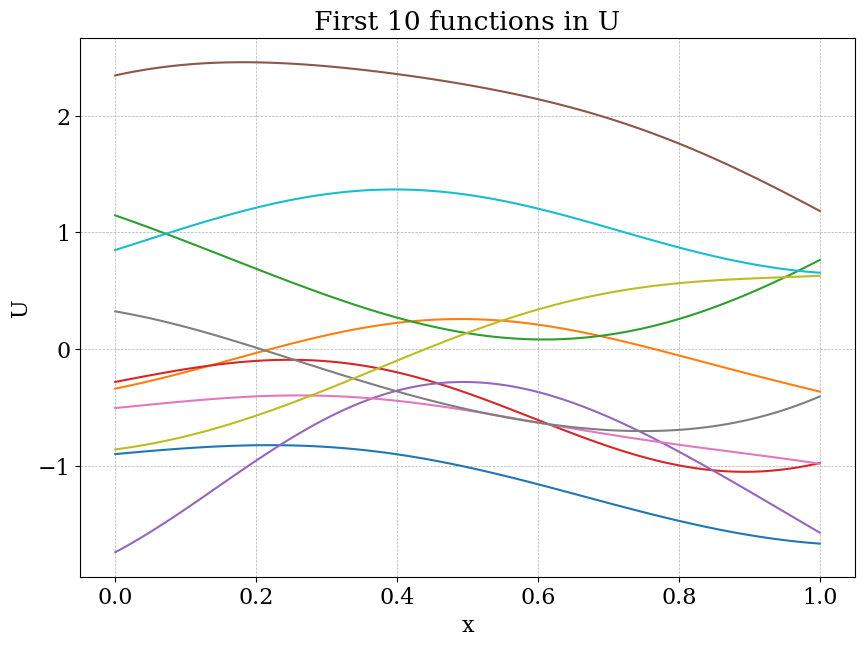

In [6]:
plt.plot(x, U[:, :10])
plt.xlabel("x")
plt.ylabel("U")
plt.title("First 10 functions in U")
plt.grid()
plt.savefig(os.path.join(PLOTS_DIR, "0101.png"))

Here are all the functions:

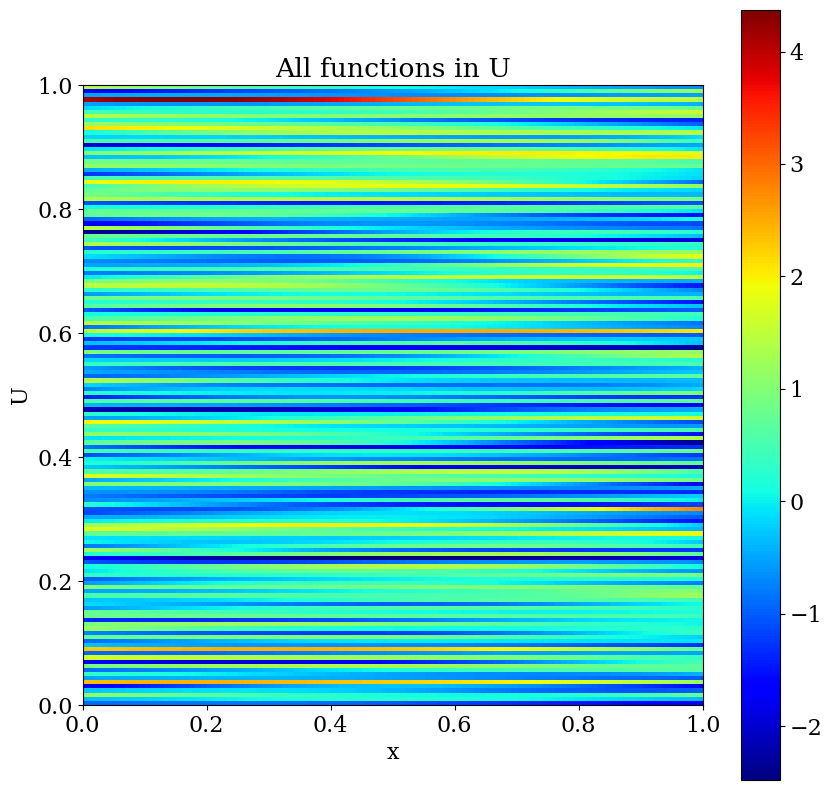

In [7]:
plt.figure(figsize=(10,10))
extent = [0, 1, 0, 1]
plt.imshow(U.T, cmap='jet', extent=extent, origin='lower')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("U")
plt.title("All functions in U")
plt.savefig(os.path.join(PLOTS_DIR, "0102.png"))

## Preprocessing

Note that DeepONet requires two inputs:
1. The random field $u_i$ with shape $b\times m$.
2. The value of $x_i$ with shape $b\times 1$.

While the output will be the value of $s_i(x_i)$ with shape $b\times 1$. Here, $b$ is the batch size.

Right now, our dataset is not in this form. We will need to preprocess it. This will be done in the following lines of code:

In [8]:
def create_dataset(m, n , x, U, S):
    """This function creates a dataset of size m*n"""
    us = np.zeros((m*n, m))
    xs = np.zeros((m*n, 1))
    ss = np.zeros((m*n, 1))
    for i in range(n):
        for j in range(m):
            us[i*m+j, :] = U[:, i]
            xs[i*m+j, :] = x[j]
            ss[i*m+j, :] = S[j, i]
    return us, xs, ss

In [9]:
us, xs, ss = create_dataset(m, n, x, U, S)
print(us.shape, xs.shape, ss.shape)

(15000, 100) (15000, 1) (15000, 1)


We can see that we now have 15000 data points!

This is a large number of points. In fact, when testing the model, the number of samples will increase by a large number. This is why we will create a function which uses a generator to generate the data in batches.

In [10]:
def batch_dataset(batch_size, us, xs, ss):
    """This function uses the torch.utils.data.DataLoader to create a batch dataset"""
    us = torch.tensor(us, dtype=torch.float32).to(device)
    xs = torch.tensor(xs, dtype=torch.float32).to(device)
    ss = torch.tensor(ss, dtype=torch.float32).to(device)
    train_dataset = torch.utils.data.TensorDataset(us, xs, ss)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    return train_dataloader

Let's see what the data looks like:

In [11]:
BATCH_SIZE = 64
train_data = batch_dataset(BATCH_SIZE, us, xs, ss)

for u_, x_, s_ in train_data:
    print(u_.shape, x_.shape, s_.shape)
    break

torch.Size([64, 100]) torch.Size([64, 1]) torch.Size([64, 1])


Excellent! Now we have the data in the required format. Next, we'll create a model and train it.

# Creating, Training and Testing the Model

## Creating the Model

DeepONet consist of two networks, the branch and the trunk. The following model is a simple implementation of DeepONet.

In [12]:
class DeepONet(nn.Module):
    def __init__(self, branch_layers, trunk_layers, activation=nn.ReLU):
        super(DeepONet, self).__init__()
        self.branch_layers = branch_layers
        self.trunk_layers = trunk_layers
        self.activation = activation

        self.bias = torch.nn.parameter.Parameter(torch.tensor(0.0))
        self.b = self.branch()
        self.t = self.trunk()

    def branch(self):
        #use self.branch_layers to define the branch network
        b1 = nn.Sequential()
        for i in range(len(self.branch_layers)-1):
            b1.add_module(f"Branch_Linear_{i+1}", nn.Linear(self.branch_layers[i], self.branch_layers[i+1]))
            b1.add_module(f"Branch_Activation_{i+1}", self.activation())
        return b1
    
    def trunk(self):
        #use self.trunk_layers to define the trunk network
        t1 = nn.Sequential()
        for i in range(len(self.trunk_layers)-1):
            t1.add_module(f"Trunk_Linear_{i+1}", nn.Linear(self.trunk_layers[i], self.trunk_layers[i+1]))
            t1.add_module(f"Trunk_Activation{i+1}", self.activation())
        return t1
    
        
    def forward(self, x1, x2):
        x1 = self.b(x1)
        x2 = self.t(x2)
        x = torch.einsum("bi,bi->b", x1, x2)
        x = torch.unsqueeze(x, 1)
        x+=self.bias
        return x
    
    def predict(self, x1, x2):
        with torch.no_grad():
            out =  self.forward(x1, x2)
            return out.detach().cpu().numpy()
    
    def summary(self):
        print("DeepONet")
        print("=============")
        print("Trunk Network")
        print("=============")
        print(self.t)
        print("=============")
        print("Branch Network")
        print("=============")
        print(self.b)

In [13]:
branch_layers = [100, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]
activation = nn.ReLU
model = DeepONet(branch_layers, trunk_layers, activation=activation)
model = model.to(device)
model.summary()

DeepONet
Trunk Network
Sequential(
  (Trunk_Linear_1): Linear(in_features=1, out_features=50, bias=True)
  (Trunk_Activation1): ReLU()
  (Trunk_Linear_2): Linear(in_features=50, out_features=50, bias=True)
  (Trunk_Activation2): ReLU()
  (Trunk_Linear_3): Linear(in_features=50, out_features=50, bias=True)
  (Trunk_Activation3): ReLU()
  (Trunk_Linear_4): Linear(in_features=50, out_features=50, bias=True)
  (Trunk_Activation4): ReLU()
  (Trunk_Linear_5): Linear(in_features=50, out_features=50, bias=True)
  (Trunk_Activation5): ReLU()
)
Branch Network
Sequential(
  (Branch_Linear_1): Linear(in_features=100, out_features=50, bias=True)
  (Branch_Activation_1): ReLU()
  (Branch_Linear_2): Linear(in_features=50, out_features=50, bias=True)
  (Branch_Activation_2): ReLU()
  (Branch_Linear_3): Linear(in_features=50, out_features=50, bias=True)
  (Branch_Activation_3): ReLU()
  (Branch_Linear_4): Linear(in_features=50, out_features=50, bias=True)
  (Branch_Activation_4): ReLU()
  (Branch_Linea

In [14]:
model.parameters()

<generator object Module.parameters at 0x7fd7d2d940b0>

The loss function will be the mean squared error. We will use the Adam optimizer.

In [14]:
def loss(y_pred, y):
    return torch.mean((y_pred - y)**2)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
epochs = 200
for i in range(epochs):
    l_total = 0
    for u_, x_, s_ in train_data:
        model.train()
        optimizer.zero_grad()
        y_pred = model(u_, x_)
        l = loss(y_pred, s_)
        l_total += l.item()
        l.backward()
        optimizer.step()
    l_total = l_total/len(train_data)
    train_losses.append(l_total)
    if (i+1) % 20 == 0:
        print(f'Epoch: {i+1:>4d}/{epochs}, Loss: {l_total:8f}')
    l_total = 0


Epoch:   20/200, Loss: 0.001230
Epoch:   40/200, Loss: 0.000607
Epoch:   60/200, Loss: 0.000204
Epoch:   80/200, Loss: 0.000111
Epoch:  100/200, Loss: 0.000180
Epoch:  120/200, Loss: 0.000073
Epoch:  140/200, Loss: 0.000196
Epoch:  160/200, Loss: 0.000062
Epoch:  180/200, Loss: 0.000056
Epoch:  200/200, Loss: 0.000048


In [25]:
#save trained model
torch.save(model.state_dict(), 'deeponet.pt')

## Evaluating The Model

### Plotting the Loss

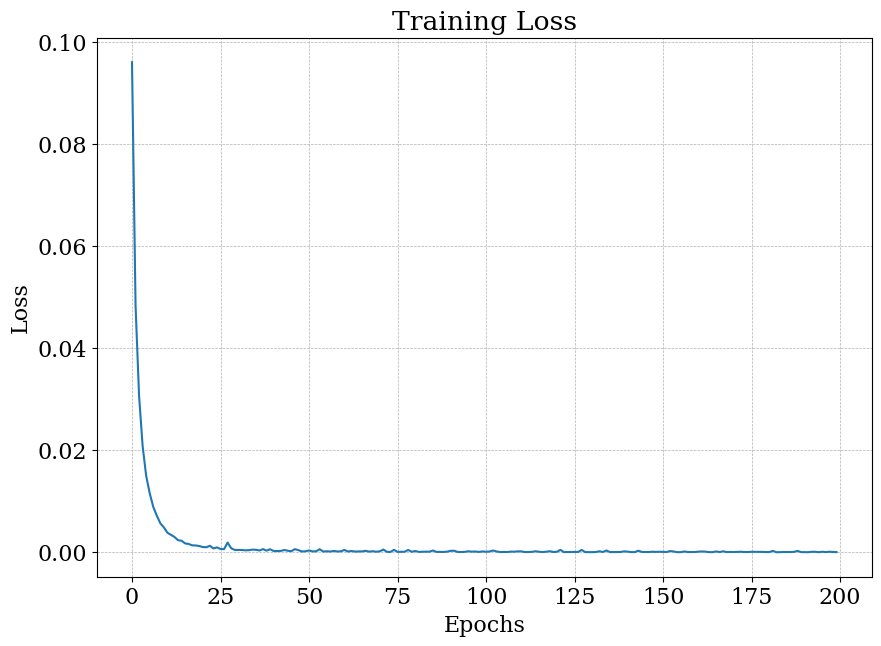

In [46]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.savefig(os.path.join(PLOTS_DIR, "0103.png"))
plt.show()

### Evaluating on the Test Dataset

First, load the test dataset:

In [27]:
x, U, S, m, n = load_data("antiderivative_aligned_test.npz")

Shape of U: (100, 1000)
Shape of S: (100, 1000)
Shape of x: (100, 1)
Number of points: 100
Number of functions: 1000
Possible number of training samples: 100000


In [28]:
us, xs, ss = create_dataset(m, n, x, U, S)
print(us.shape, xs.shape, ss.shape)

(100000, 100) (100000, 1) (100000, 1)


So, there are about 100,000 test data points. We will use a generator to load the data in batches.

In [29]:
BATCH_SIZE = 256
test_data = batch_dataset(BATCH_SIZE, us, xs, ss)

for u_, x_, s_ in test_data:
    print(u_.shape, x_.shape, s_.shape)
    break

torch.Size([256, 100]) torch.Size([256, 1]) torch.Size([256, 1])


Now, let's calculate the mean squared error for the test data.

In [31]:
model.eval()
l_total = 0
for u_, x_, s_ in test_data:
    y_pred = model(u_, x_)
    l = loss(y_pred, s_)
    l_total += l.item()
l_total = l_total/len(test_data)
print(f'Testing Loss: {l_total:6f}')

Testing Loss: 0.000942


This is close to the loss we got during training.

### Evaluating the Model on Custom Functions

Here, we'll have a look at the model's performance on some custom functions. We will use two functions:

1. $e^{-x}$
2. $\cos(5x)$
3. $\cos(x)\sin(x)$

We already know the integration of these functions. The analytical solution will be plotted along with the DeepONet's solution.


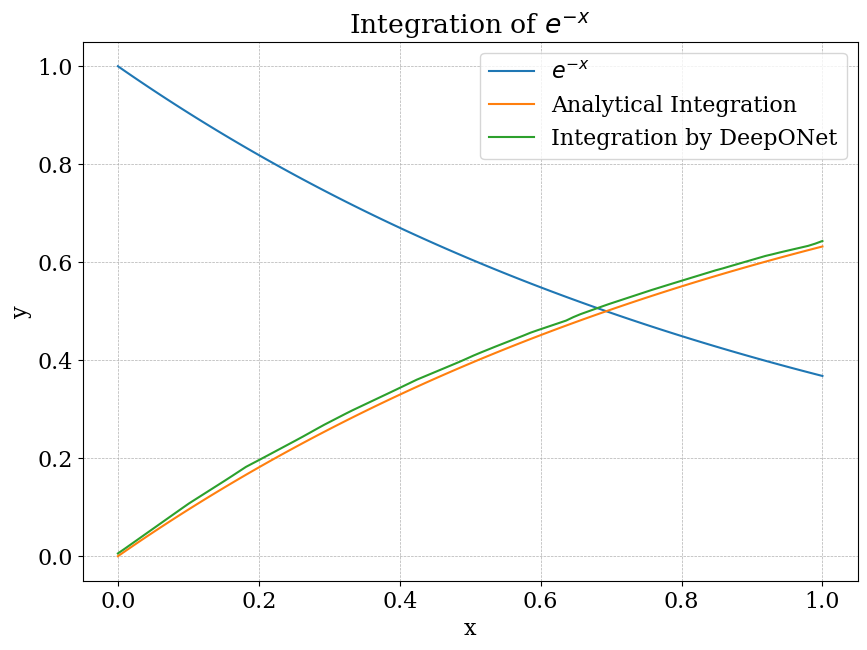

In [47]:
my_func = lambda x: np.exp(-x)
inter = lambda x: -np.exp(-x) + 1
u_t = my_func(x)
s_t = inter(x)
u_t = np.squeeze(u_t)
model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype=torch.float32).to(device)
p = model.predict(u_t_, x_)

plt.plot(x, u_t, label="$e^{-x}$")
plt.plot(x, s_t, label="Analytical Integration")
plt.plot(x, p, label="Integration by DeepONet")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Integration of $e^{-x}$")
plt.grid()
plt.savefig(os.path.join(PLOTS_DIR, "0104.png"))

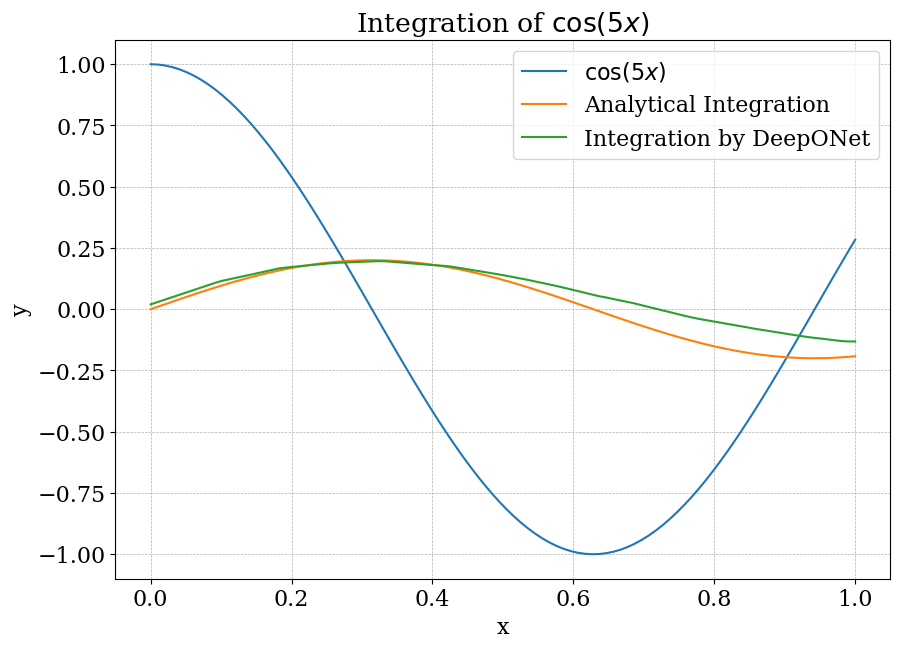

In [48]:
my_func = lambda x: np.cos(5*x)
inter = lambda x: 1/5*np.sin(5*x)
u_t = my_func(x)
s_t = inter(x)
u_t = np.squeeze(u_t)
model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype=torch.float32).to(device)
p = model.predict(u_t_, x_)

plt.plot(x, u_t, label="$\cos(5x)$")
plt.plot(x, s_t, label="Analytical Integration")
plt.plot(x, p, label="Integration by DeepONet")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Integration of $\cos(5x)$")
plt.grid()
plt.savefig(os.path.join(PLOTS_DIR, "0105.png"))

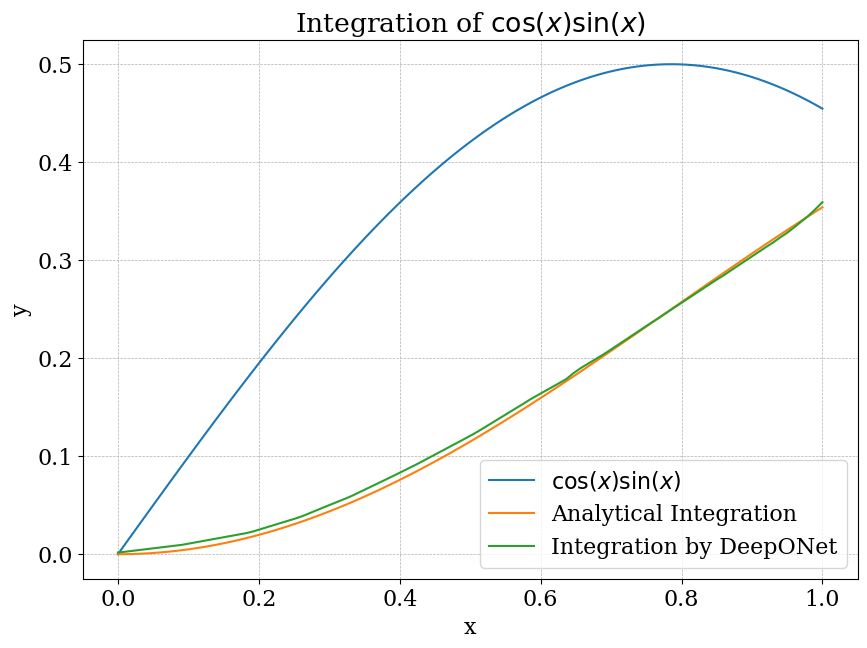

In [50]:
my_func = lambda x: np.cos(x)*np.sin(x)
inter = lambda x: 1/2*(np.sin(x))**2
u_t = my_func(x)
s_t = inter(x)
u_t = np.squeeze(u_t)
model.eval()
u_t_ = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0).to(device)
x_ = torch.tensor(x, dtype=torch.float32).to(device)
p = model.predict(u_t_, x_)

plt.plot(x, u_t, label="$\cos(x)\sin(x)$")
plt.plot(x, s_t, label="Analytical Integration")
plt.plot(x, p, label="Integration by DeepONet")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Integration of $\cos(x)\sin(x)$")
plt.grid()
plt.savefig(os.path.join(PLOTS_DIR, "0106.png"))

We can see that though the solutions are not perfect, they are not bad too. It can be improved by increasing the number of layers in the network or training for more epochs.